In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm  # Progress bar for Jupyter Notebooks
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.metrics import classification_report

In [1]:


# Corrected path for Windows: use double backslashes or a raw string literal
file_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\Final update\corrected_lexicon.xlsx"

# Load the dataset
df = pd.read_excel(file_path)


# Rename columns to match the expected structure
df.columns = ['ciluba', 'french', 'english', 'afrikaans', 'zulu', 'sepedi', 'score', 'sentiment', 'nature']

# Handle missing values (if any)
df = df.dropna(subset=['score', 'sentiment', 'nature'])

# Encode categorical variables
label_encoder_sentiment = LabelEncoder()
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentiment'])

label_encoder_nature = LabelEncoder()
df['nature_encoded'] = label_encoder_nature.fit_transform(df['nature'])

# Check and remove classes with fewer than 2 instances for stratification
class_counts = df['nature'].value_counts()
classes_to_keep = class_counts[class_counts >= 2].index
df = df[df['nature'].isin(classes_to_keep)]

# Re-encode after filtering
df['nature_encoded'] = label_encoder_nature.fit_transform(df['nature'])

# Prepare features (X) and target (y)
X = df[['score', 'sentiment_encoded']]
y = df['nature_encoded']

# Convert 'score' to numeric, handling errors and filling NaN values
X.loc[:, 'score'] = pd.to_numeric(X['score'], errors='coerce').fillna(0)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (with stratification if possible)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Define hyperparameter grids for each model
param_grids = {
    "SVM": {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto']
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Random Forest": {
        'n_estimators': [50, 100], 
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Gaussian Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }
}

# Models to evaluate
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

# Function to perform grid search for a single model with progress bar
def perform_grid_search(model_name, model, param_grid):
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=5, 
        verbose=0, 
        n_jobs=-1
    )
    
    # Use tqdm to display the progress
    with tqdm(total=len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) 
              if model_name == "SVM" else len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) 
              if model_name == "Decision Tree" else len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) 
              if model_name == "Random Forest" else len(param_grid['var_smoothing']), desc=f"Training {model_name}", leave=True) as pbar:
        grid_search.fit(X_train, y_train)
        pbar.update(1)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}\n")
    return best_model

# Store the best models in a dictionary
best_models = {}

# Run grid search for each model separately with progress tracking
for model_name, model in models.items():
    best_models[model_name] = perform_grid_search(model_name, model, param_grids[model_name])

# Evaluate the best models on the test set with progress bar
results = []
for name, model in tqdm(best_models.items(), desc="Evaluating models"):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Append the results as a dictionary to the list
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)

# Sort results by Accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Display the results
print("Hyperparameter Tuning Results:")
display(results_df)


Performing Grid Search for SVM...


Training SVM:   0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.6743

Performing Grid Search for Decision Tree...


Training Decision Tree:   0%|          | 0/12 [00:00<?, ?it/s]

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation accuracy for Decision Tree: 0.6743

Performing Grid Search for Random Forest...


C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Training Random Forest:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy for Random Forest: 0.6755

Performing Grid Search for Gaussian Naive Bayes...


Training Gaussian Naive Bayes:   0%|          | 0/3 [00:00<?, ?it/s]

Best parameters for Gaussian Naive Bayes: {'var_smoothing': 1e-09}
Best cross-validation accuracy for Gaussian Naive Bayes: 0.6284



C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Evaluating models:   0%|          | 0/4 [00:00<?, ?it/s]

Hyperparameter Tuning Results:


,Model,Accuracy,Precision,Recall,F1-Score
2,Random Forest,0.655763,0.611037,0.655763,0.561988
0,SVM,0.654206,0.605091,0.654206,0.559285
1,Decision Tree,0.654206,0.604437,0.654206,0.558882
3,Gaussian Naive Bayes,0.599688,0.540980,0.599688,0.547012


Evaluating models:   0%|          | 0/4 [00:00<?, ?it/s]

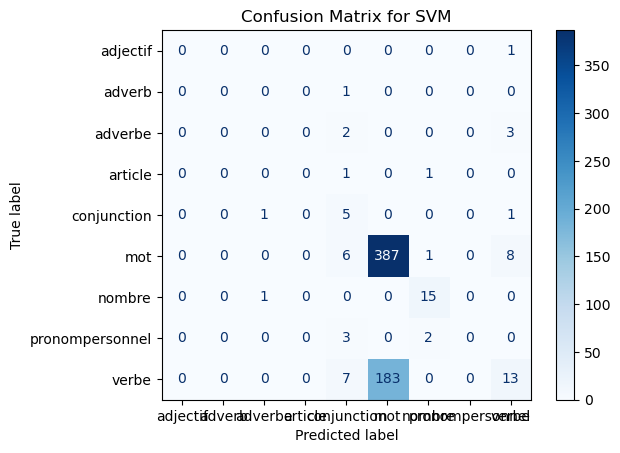

Classification Report for SVM:
                 precision    recall  f1-score   support

       adjectif       0.00      0.00      0.00         1
         adverb       0.00      0.00      0.00         1
        adverbe       0.00      0.00      0.00         5
        article       0.00      0.00      0.00         2
    conjunction       0.20      0.71      0.31         7
            mot       0.68      0.96      0.80       402
         nombre       0.79      0.94      0.86        16
pronompersonnel       0.00      0.00      0.00         5
          verbe       0.50      0.06      0.11       203

       accuracy                           0.65       642
      macro avg       0.24      0.30      0.23       642
   weighted avg       0.61      0.65      0.56       642



C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

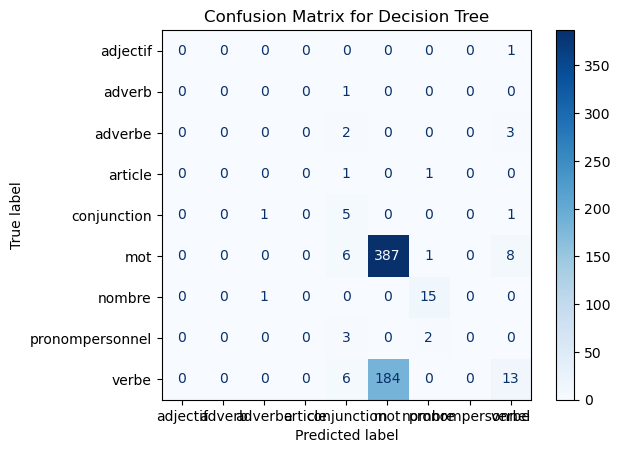

Classification Report for Decision Tree:
                 precision    recall  f1-score   support

       adjectif       0.00      0.00      0.00         1
         adverb       0.00      0.00      0.00         1
        adverbe       0.00      0.00      0.00         5
        article       0.00      0.00      0.00         2
    conjunction       0.21      0.71      0.32         7
            mot       0.68      0.96      0.80       402
         nombre       0.79      0.94      0.86        16
pronompersonnel       0.00      0.00      0.00         5
          verbe       0.50      0.06      0.11       203

       accuracy                           0.65       642
      macro avg       0.24      0.30      0.23       642
   weighted avg       0.60      0.65      0.56       642



C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

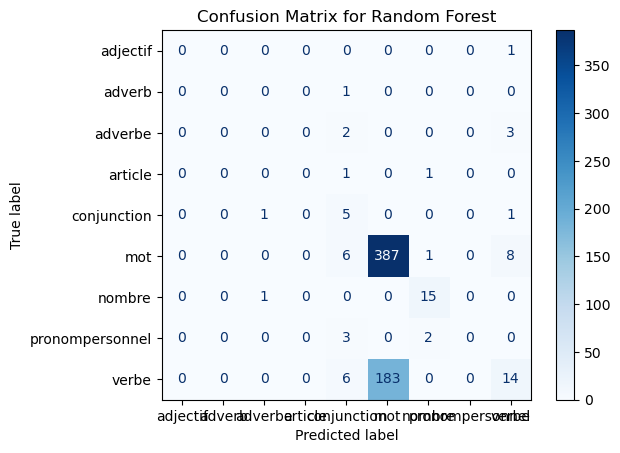

Classification Report for Random Forest:
                 precision    recall  f1-score   support

       adjectif       0.00      0.00      0.00         1
         adverb       0.00      0.00      0.00         1
        adverbe       0.00      0.00      0.00         5
        article       0.00      0.00      0.00         2
    conjunction       0.21      0.71      0.32         7
            mot       0.68      0.96      0.80       402
         nombre       0.79      0.94      0.86        16
pronompersonnel       0.00      0.00      0.00         5
          verbe       0.52      0.07      0.12       203

       accuracy                           0.66       642
      macro avg       0.24      0.30      0.23       642
   weighted avg       0.61      0.66      0.56       642



C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

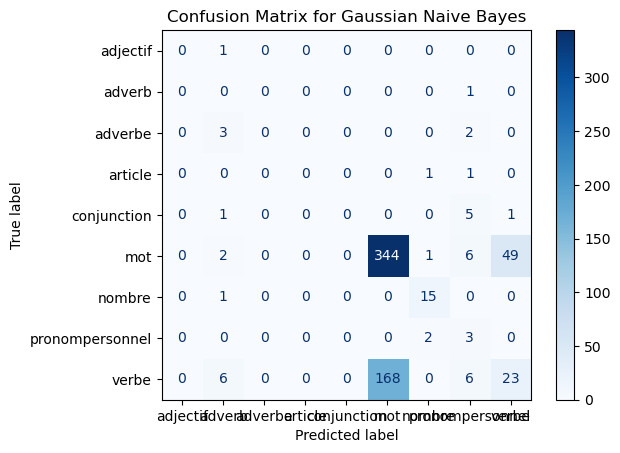

Classification Report for Gaussian Naive Bayes:
                 precision    recall  f1-score   support

       adjectif       0.00      0.00      0.00         1
         adverb       0.00      0.00      0.00         1
        adverbe       0.00      0.00      0.00         5
        article       0.00      0.00      0.00         2
    conjunction       0.00      0.00      0.00         7
            mot       0.67      0.86      0.75       402
         nombre       0.79      0.94      0.86        16
pronompersonnel       0.12      0.60      0.21         5
          verbe       0.32      0.11      0.17       203

       accuracy                           0.60       642
      macro avg       0.21      0.28      0.22       642
   weighted avg       0.54      0.60      0.55       642



C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ryand\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [5]:
# After evaluating the models
from sklearn.metrics import classification_report

# Evaluate the best models on the test set with progress bar
results = []
for name, model in tqdm(best_models.items(), desc="Evaluating models"):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Append the results as a dictionary to the list
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_nature.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    
    # Classification Report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder_nature.classes_))


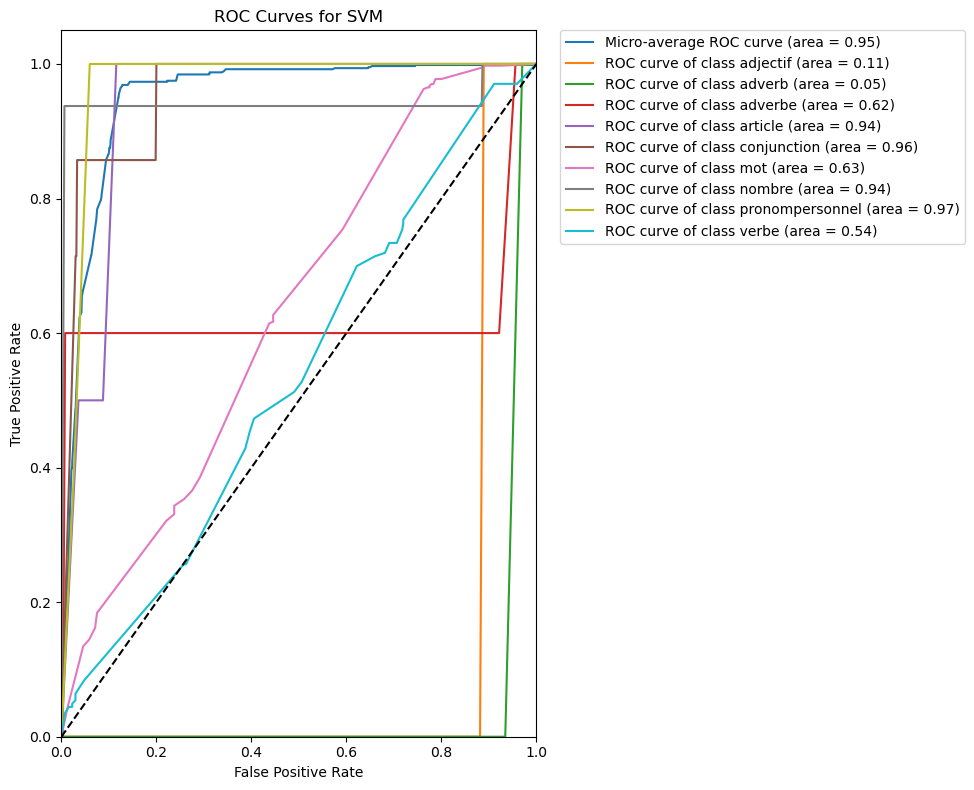

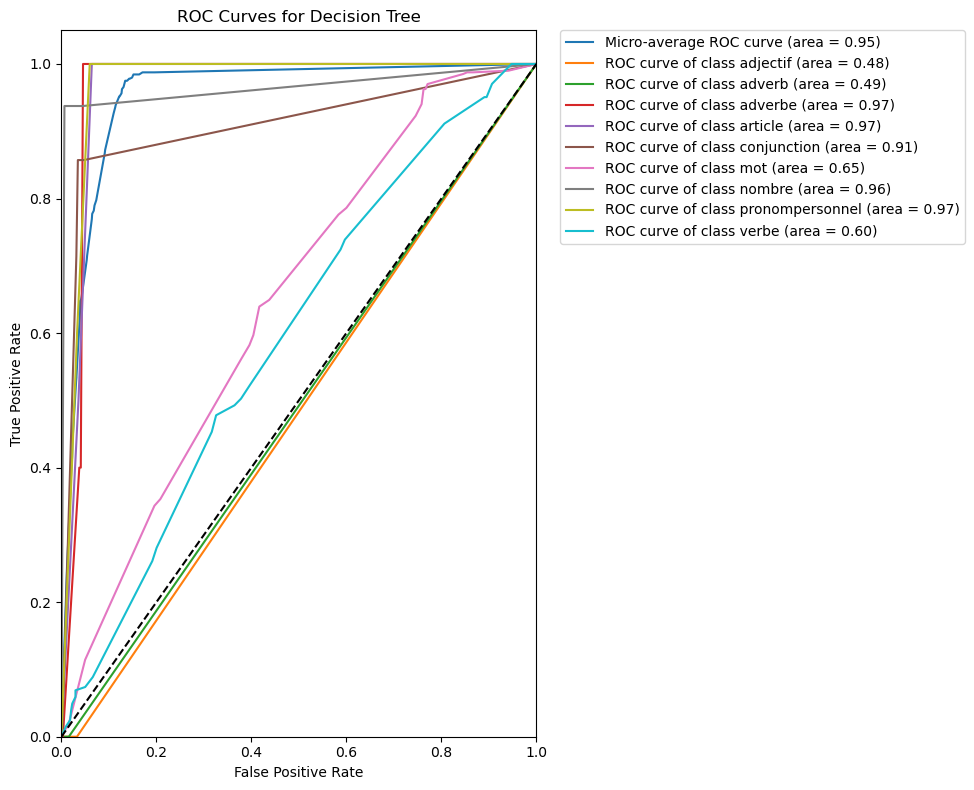

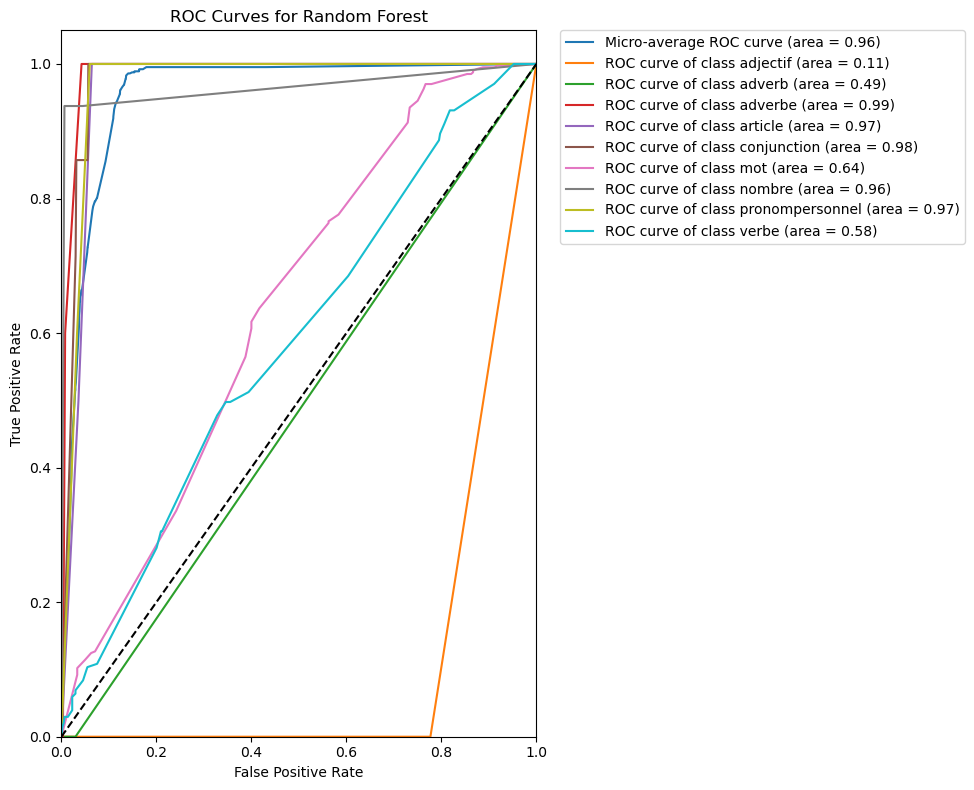

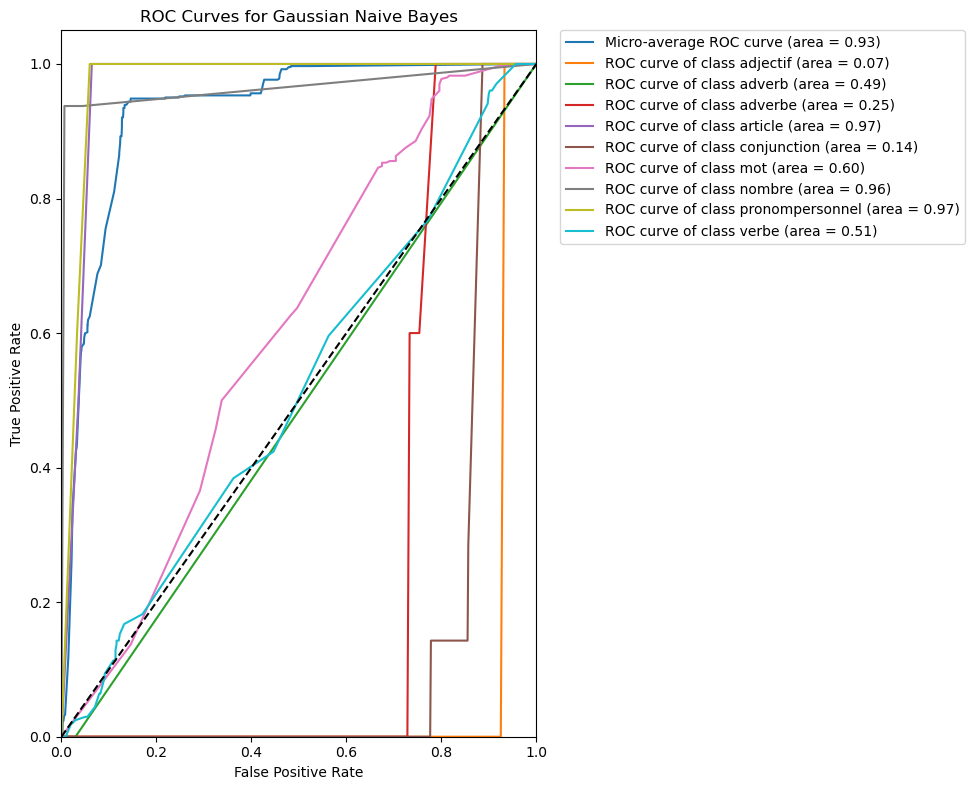

In [13]:
# Binarize the output labels for ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming y has classes 0 to n_classes-1
n_classes = len(label_encoder_nature.classes_)
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Create ROC curves for each classifier
for name, model in best_models.items():
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if y_score.ndim == 1 or y_score.shape[1] == 1:
            # Binary case
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score)
        else:
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(label_encoder_nature.classes_[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC Curves for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Place legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


In [12]:
def perform_grid_search(model_name, model, param_grid):
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=5, 
        verbose=0, 
        n_jobs=-1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    # Extract results into a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Plot mean test scores against hyperparameters
    plt.figure(figsize=(10, 8))
    
    if model_name == "SVM":
        # SVM has multiple hyperparameters: C, kernel, gamma
        # We'll create separate heatmaps for each kernel
        kernels = param_grid['kernel']
        for kernel in kernels:
            subset = results[results['param_kernel'] == kernel]
            pivot_table = subset.pivot_table(
                values='mean_test_score',
                index='param_C',
                columns='param_gamma'
            )
            sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
            plt.title(f'Grid Search Accuracy for SVM (Kernel={kernel})')
            plt.xlabel('Gamma')
            plt.ylabel('C')
            plt.tight_layout()
            plt.show()
    
    elif model_name == "Decision Tree":
        # Decision Tree has max_depth, min_samples_split, min_samples_leaf
        # We'll create separate heatmaps for each min_samples_split
        min_splits = param_grid['min_samples_split']
        for split in min_splits:
            subset = results[results['param_min_samples_split'] == split]
            pivot_table = subset.pivot_table(
                values='mean_test_score',
                index='param_max_depth',
                columns='param_min_samples_leaf'
            )
            sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
            plt.title(f'Grid Search Accuracy for Decision Tree (min_samples_split={split})')
            plt.xlabel('min_samples_leaf')
            plt.ylabel('max_depth')
            plt.tight_layout()
            plt.show()
    
    elif model_name == "Random Forest":
        # Random Forest has n_estimators, max_depth, min_samples_split, min_samples_leaf
        # For simplicity, we'll visualize n_estimators vs max_depth
        pivot_table = results.pivot_table(
            values='mean_test_score',
            index='param_n_estimators',
            columns='param_max_depth'
        )
        sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
        plt.title('Grid Search Accuracy for Random Forest')
        plt.xlabel('max_depth')
        plt.ylabel('n_estimators')
        plt.tight_layout()
        plt.show()
    
    elif model_name == "Gaussian Naive Bayes":
        # Gaussian NB has only var_smoothing as hyperparameter
        plt.plot(results['param_var_smoothing'], results['mean_test_score'], marker='o')
        plt.title('Grid Search Accuracy for Gaussian Naive Bayes')
        plt.xlabel('Var Smoothing')
        plt.ylabel('Mean Test Score')
        plt.xscale('log')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"No plotting defined for {model_name}")
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}\n")
    return best_model



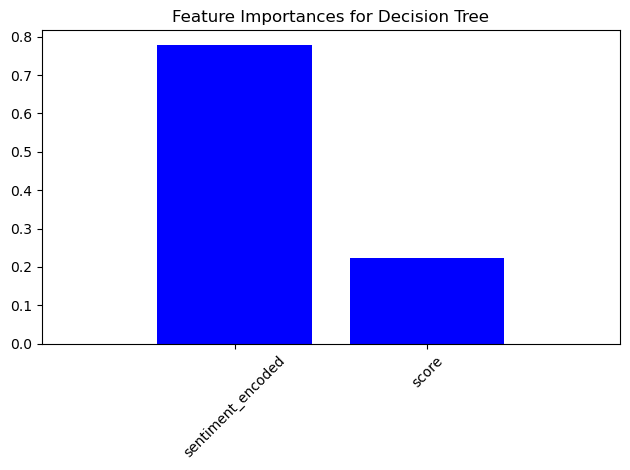

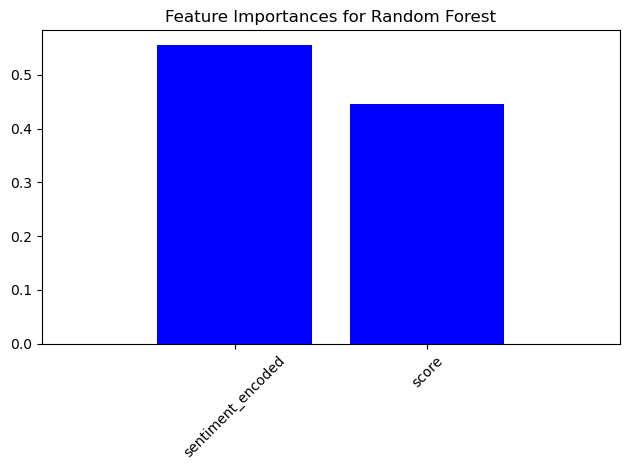

In [10]:
# Feature Importance for Decision Tree and Random Forest
for name in ['Decision Tree', 'Random Forest']:
    model = best_models[name]
    importances = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importances)[::-1]
    
    plt.figure()
    plt.title(f'Feature Importances for {name}')
    plt.bar(range(X.shape[1]), importances[indices], color='b', align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()


In [ ]:
Confusion Matrices: Provide a quick way to see how well the model is performing on each class.
ROC Curves: Although more challenging with multi-class, they still offer insight into the trade-off between true positive rates and false positive rates.
Cross-Validation Scores: Heatmaps help visualize how different hyperparameters affect model performance.
Feature Importance: Shows which features are most influential in making predictions.

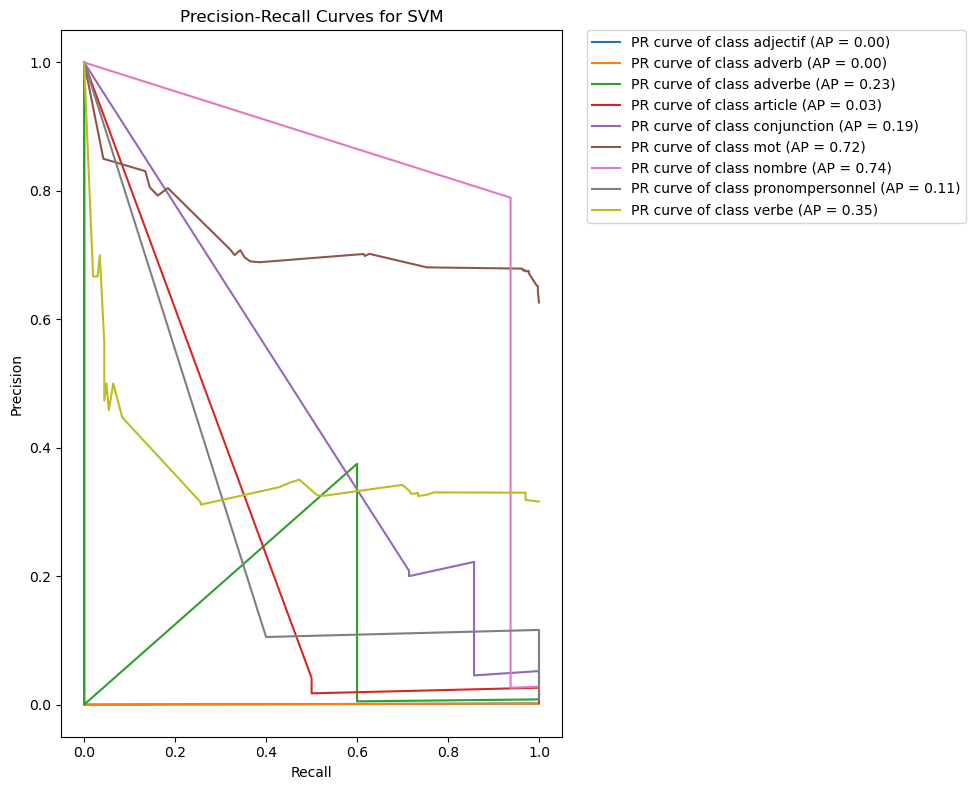

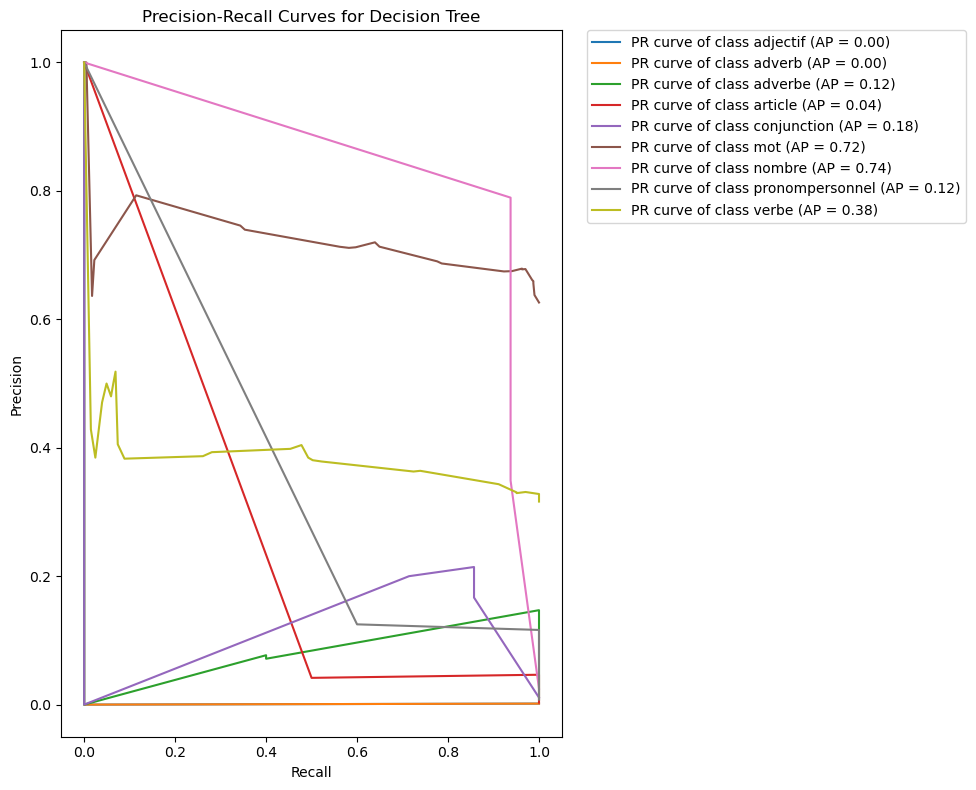

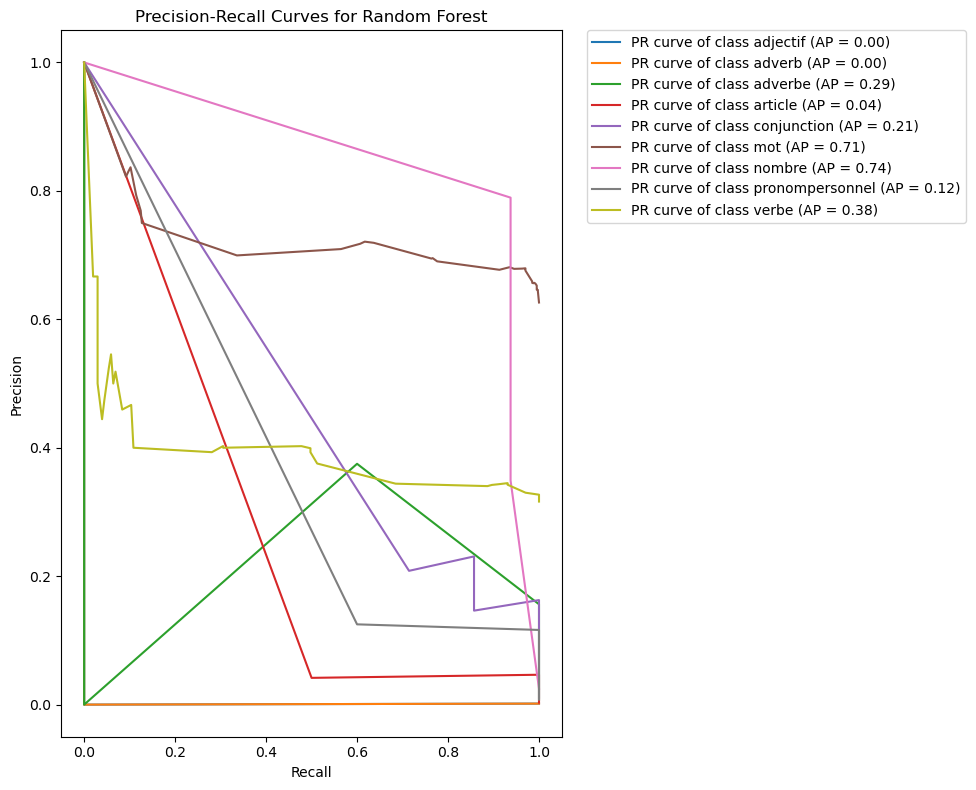

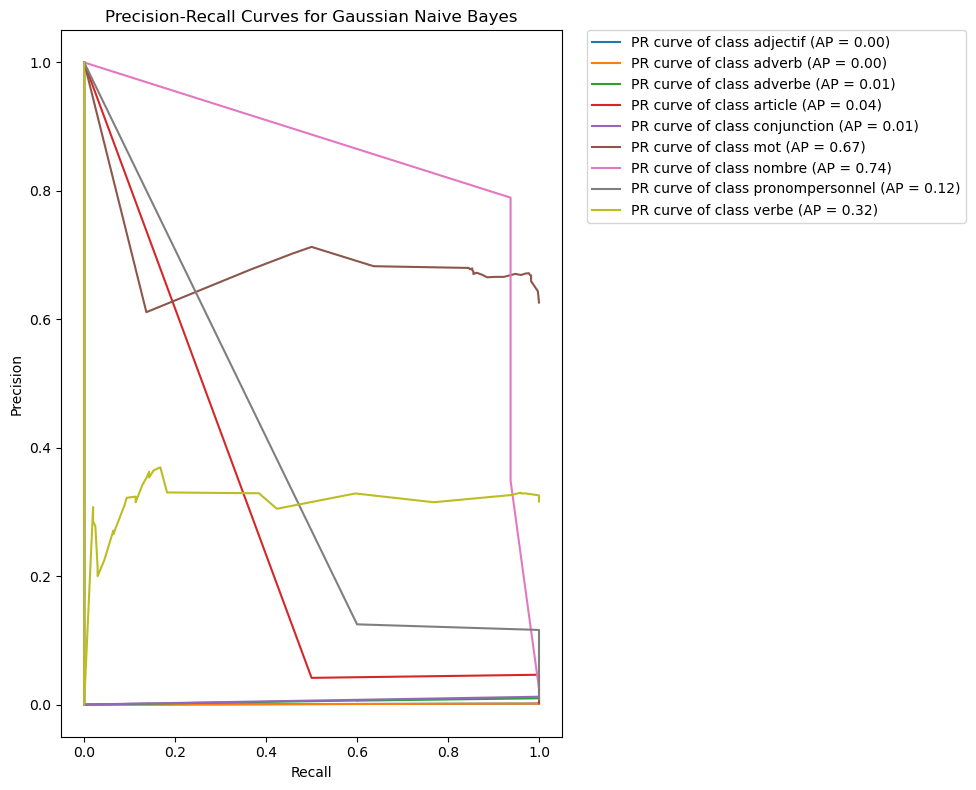

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curves
for name, model in best_models.items():
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        if y_score.ndim == 1 or y_score.shape[1] == 1:
            # Binary case
            precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score)
        else:
            precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i],
                 label='PR curve of class {0} (AP = {1:0.2f})'
                       ''.format(label_encoder_nature.classes_[i], average_precision[i]))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for {name}')
    
    # Place legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()



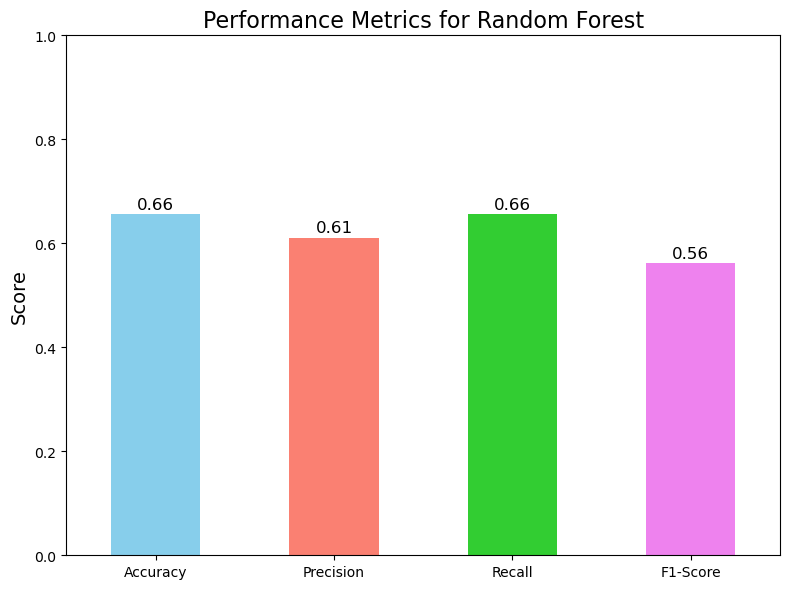

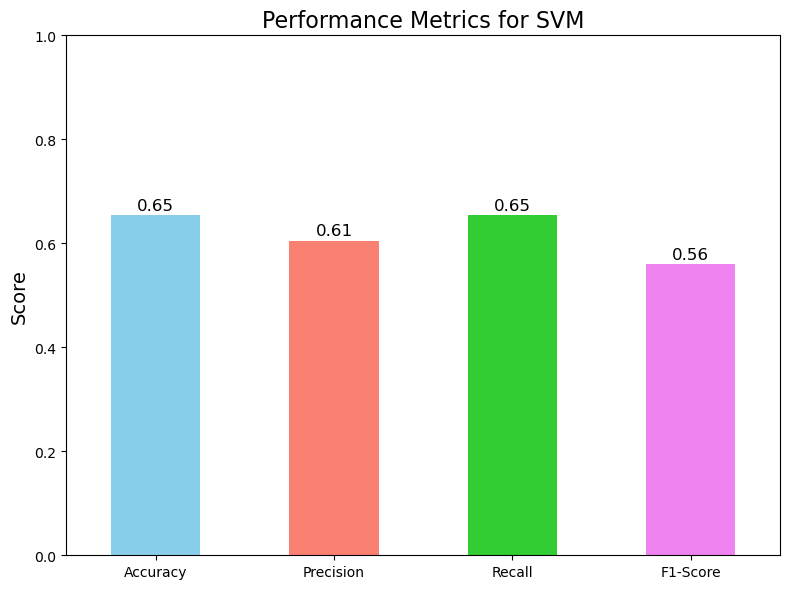

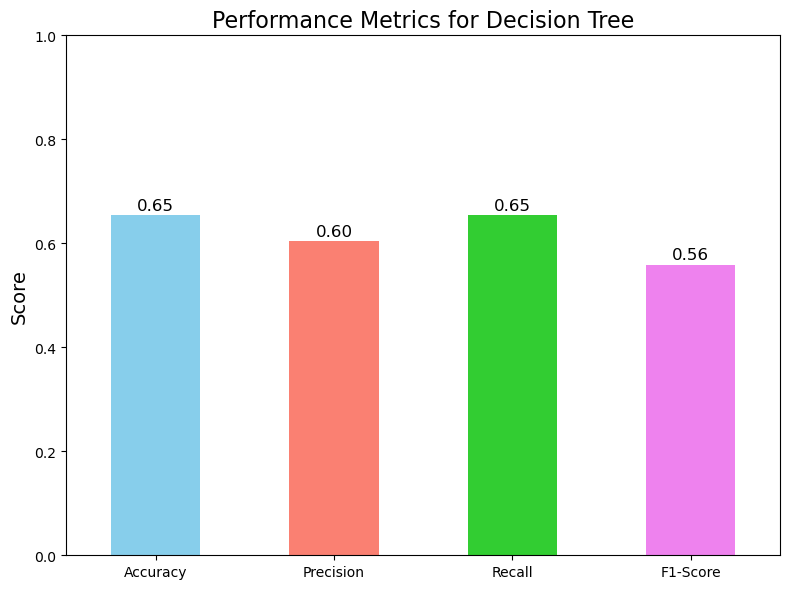

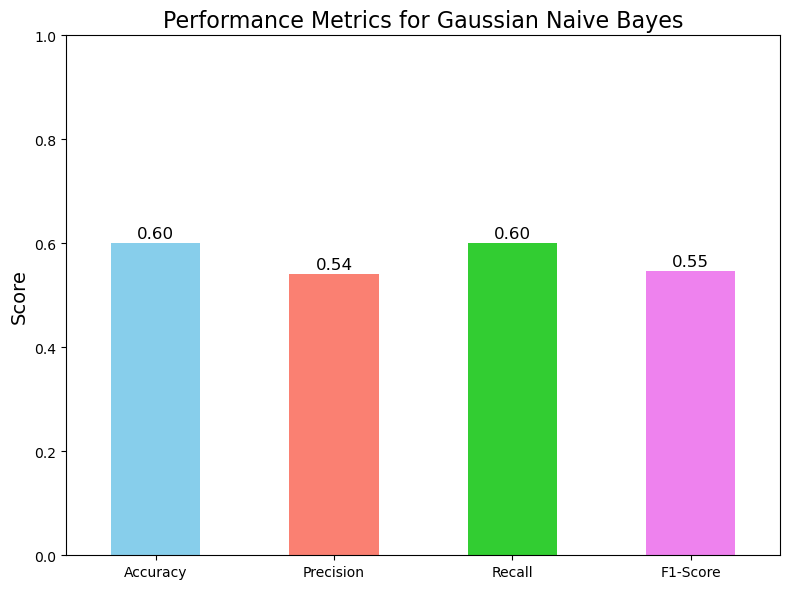

In [15]:
# Plotting Accuracy, Precision, Recall, and F1-Score for Each Model
import matplotlib.pyplot as plt

# Iterate over each model's results
for index, row in results_df.iterrows():
    model = row['Model']
    metrics = row[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
    
    # Create a bar plot for the metrics
    plt.figure(figsize=(8, 6))
    metrics.plot(kind='bar', color=['skyblue', 'salmon', 'limegreen', 'violet'])
    plt.title(f'Performance Metrics for {model}', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1)  # Since all metrics are between 0 and 1
    plt.xticks(rotation=0)
    
    # Annotate each bar with its value
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()


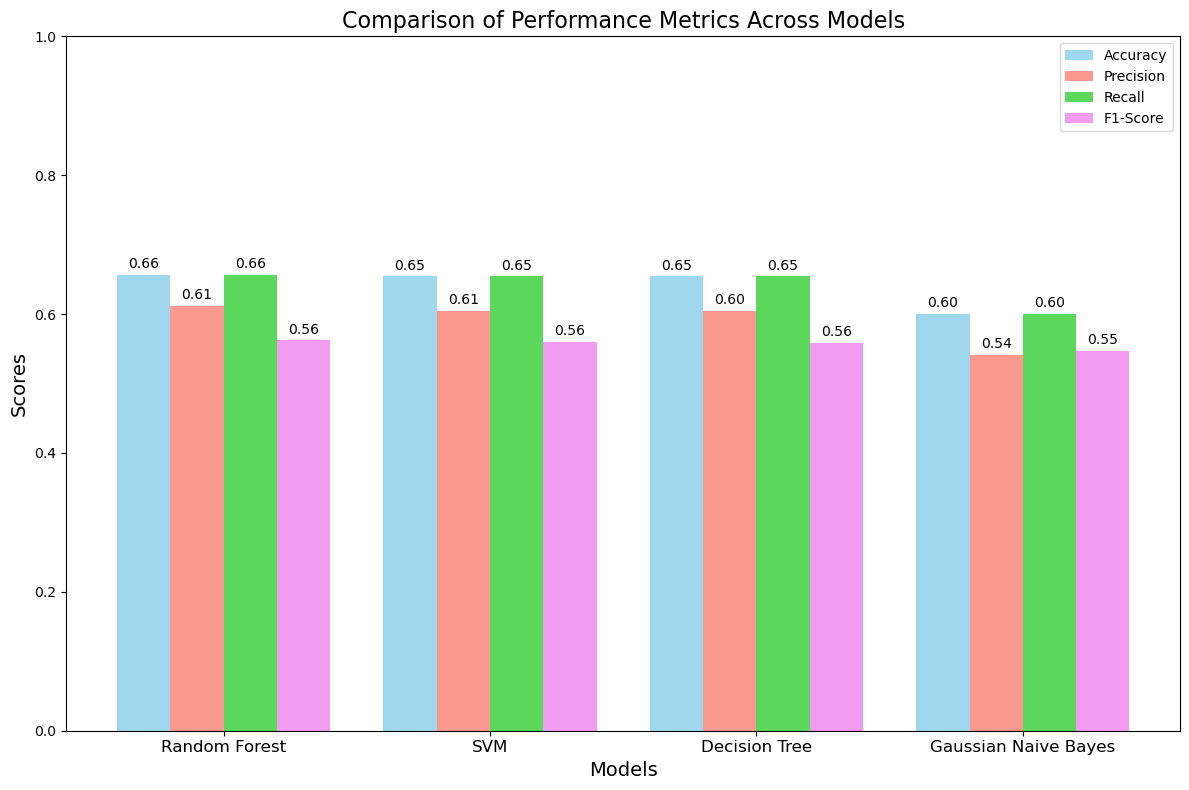

In [16]:
# Grouped Bar Chart for All Models' Metrics
import numpy as np

# Define the metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
n_metrics = len(metrics)
n_models = len(results_df)
bar_width = 0.2
opacity = 0.8

# Set positions for each group of bars
index = np.arange(n_models)

# Create a figure and axis
plt.figure(figsize=(12, 8))

# Define colors for each metric
colors = ['skyblue', 'salmon', 'limegreen', 'violet']

# Plot each metric
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, results_df[metric], bar_width,
            alpha=opacity, label=metric, color=colors[i])

# Configure the x-axis with model names
plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparison of Performance Metrics Across Models', fontsize=16)
plt.xticks(index + bar_width * (n_metrics - 1) / 2, results_df['Model'], fontsize=12)
plt.ylim(0, 1)  # Since all metrics are between 0 and 1

# Add legend
plt.legend()

# Annotate bars with their values
for i in range(n_metrics):
    for j in range(n_models):
        plt.text(index[j] + i * bar_width, results_df.iloc[j][metrics[i]] + 0.01,
                 f"{results_df.iloc[j][metrics[i]]:.2f}",
                 ha='center', fontsize=10)

plt.tight_layout()
plt.show()


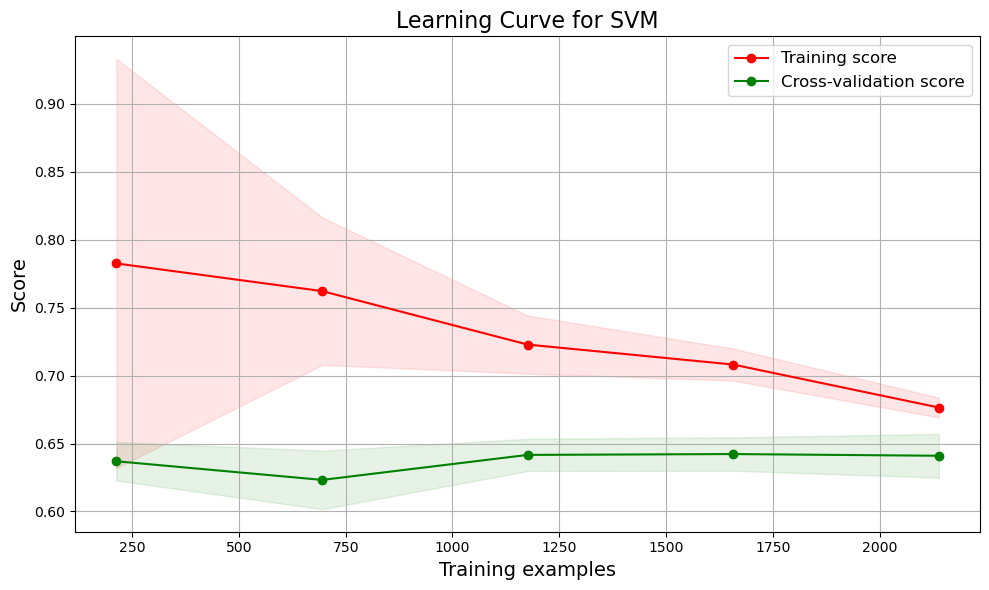

In [17]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=16)
    plt.xlabel("Training examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage for SVM
plot_learning_curve(SVC(probability=True, random_state=42, C=10, gamma='auto', kernel='rbf'), 
                   "Learning Curve for SVM",
                   X_scaled, y, cv=3)


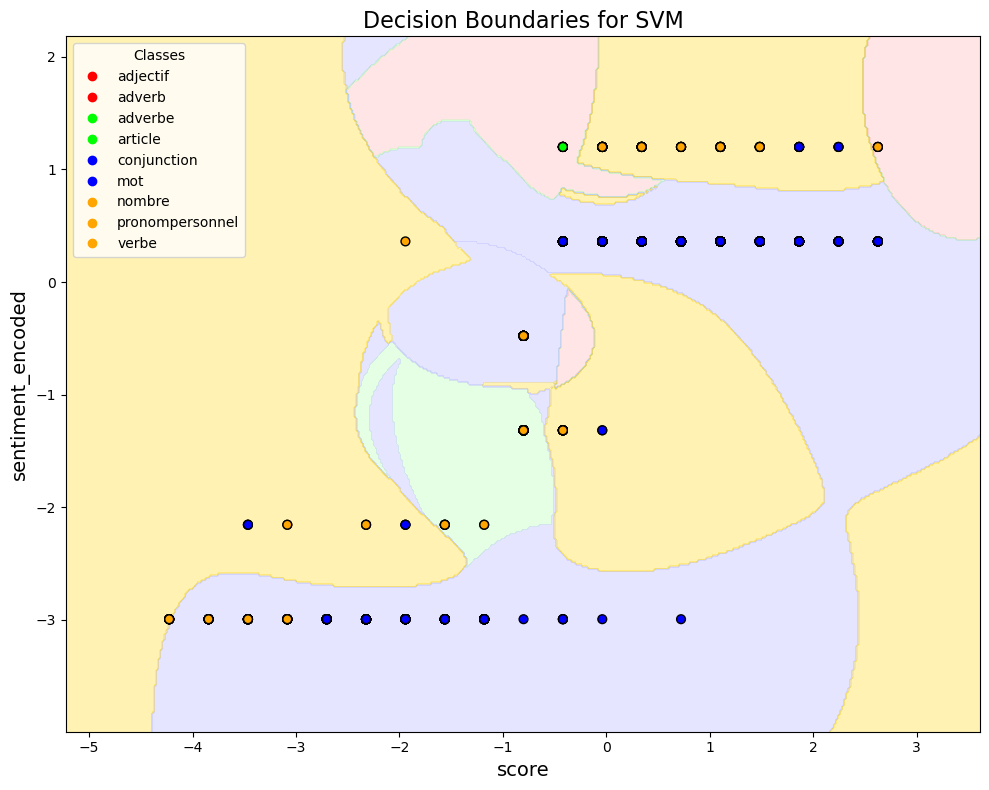

In [22]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundaries(X, y, model, title):
    # Define the color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFD700'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FFA500'])
    
    # Create a mesh grid
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict class using the model
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
    
    # Create a legend
    handles, labels = scatter.legend_elements()
    plt.legend(handles, label_encoder_nature.classes_, title="Classes")
    
    plt.title(f'Decision Boundaries for {title}', fontsize=16)
    plt.xlabel('score', fontsize=14)
    plt.ylabel('sentiment_encoded', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage for SVM
plot_decision_boundaries(X_scaled, y, best_models['SVM'], 'SVM')


In [30]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots the learning curve for a given estimator.

    Parameters:
    - estimator: The machine learning model to evaluate.
    - title: The title of the plot.
    - X: Feature matrix.
    - y: Target vector.
    - cv: Cross-validation splitting strategy.
    - n_jobs: Number of jobs to run in parallel.
    - train_sizes: Relative or absolute numbers of training examples.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=16)
    plt.xlabel("Training examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    
    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )
    
    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    
    # Fill between for training scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    
    # Fill between for cross-validation scores
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the mean training and cross-validation scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.show()



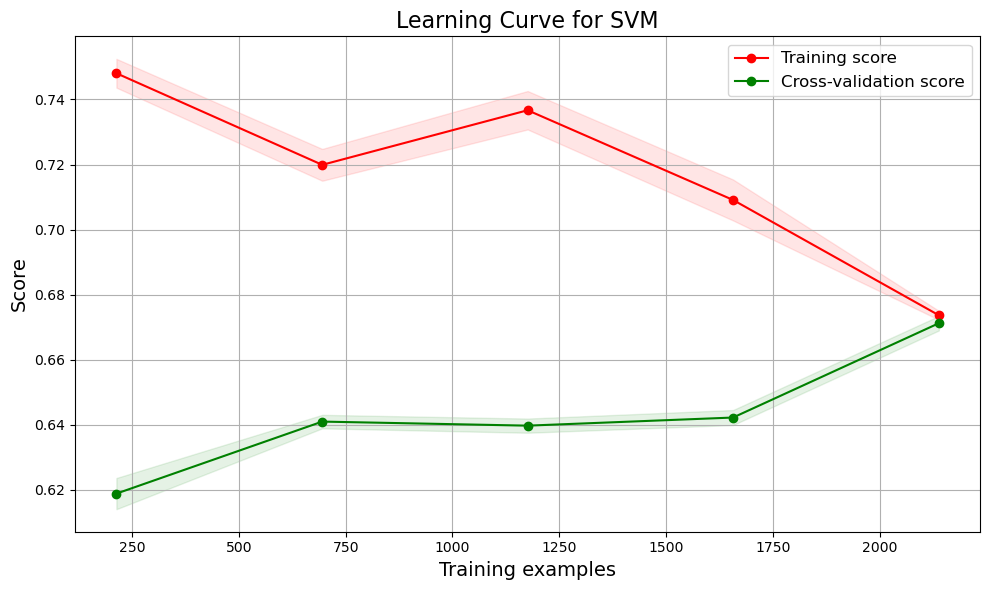

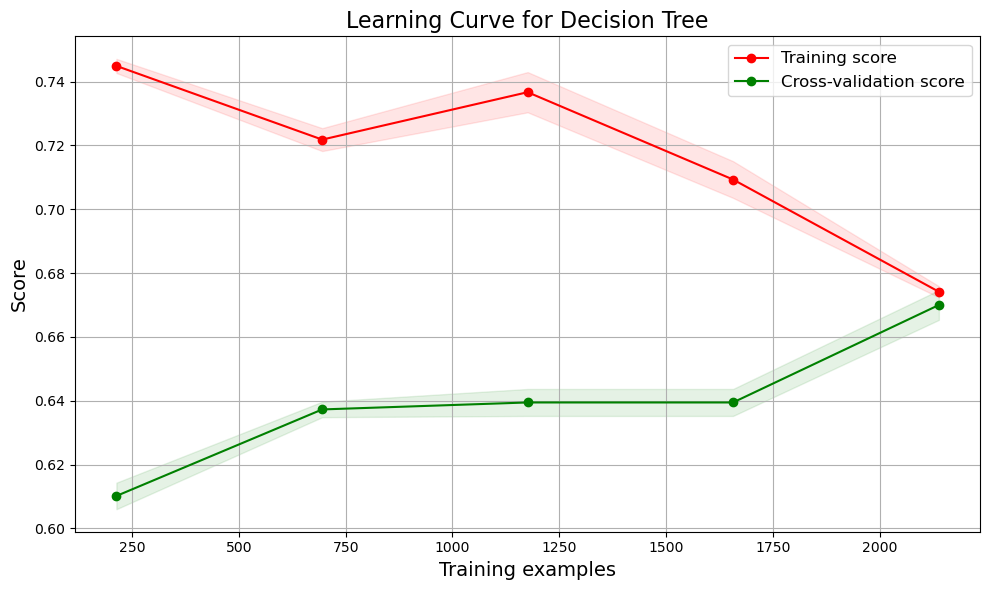

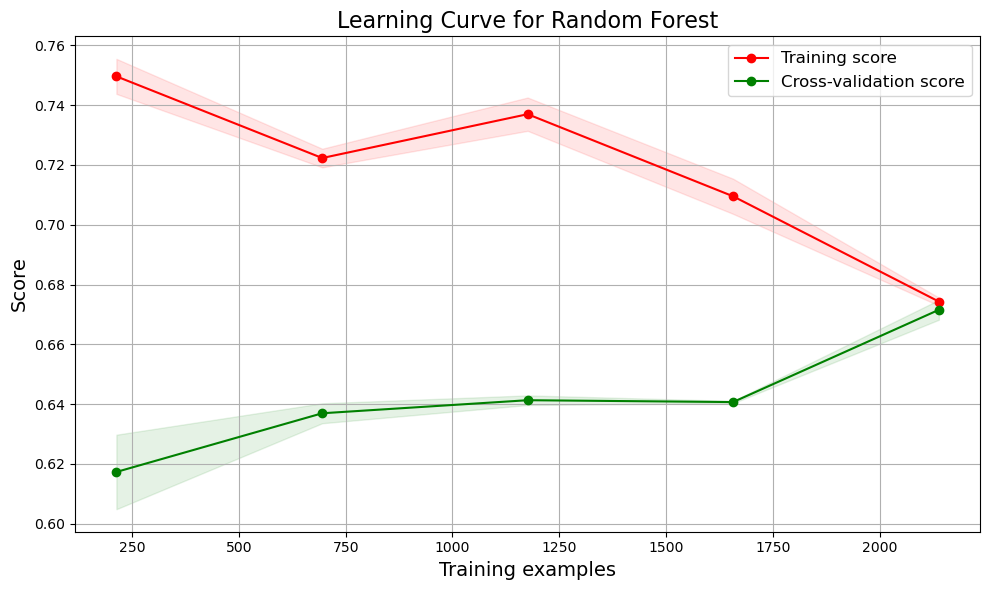

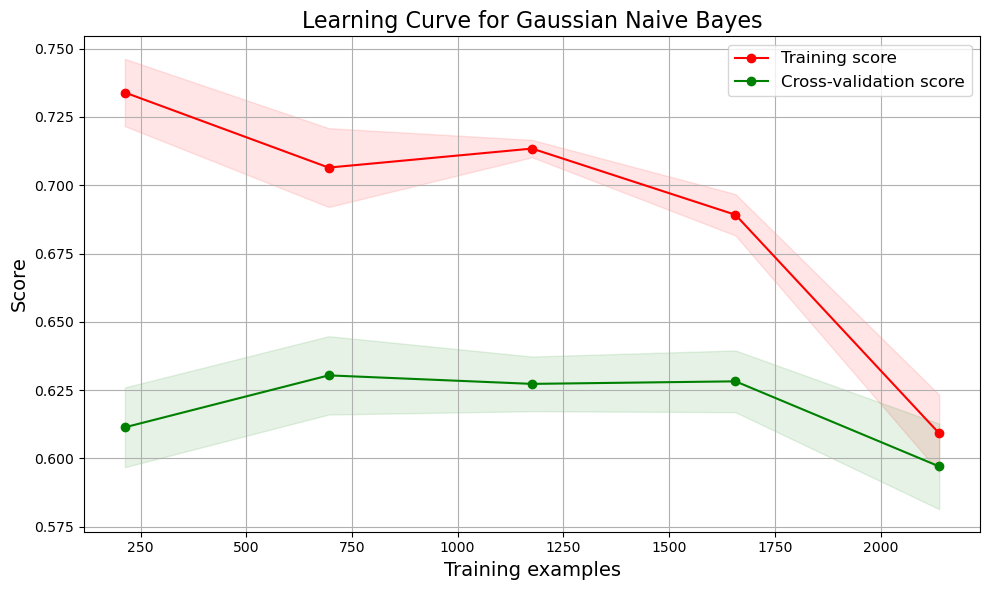

In [31]:

# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm  # For progress tracking (optional)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Iterate over each model and plot its learning curve
for model_name, model in best_models.items():
    title = f'Learning Curve for {model_name}'
    estimator = model
    plot_learning_curve(
        estimator=estimator,
        title=title,
        X=X_scaled,
        y=y,
        cv=cv,
        n_jobs=-1,  # Utilize all available cores
        train_sizes=np.linspace(.1, 1.0, 5)  # 10%, 32.5%, 55%, 77.5%, 100% of the training data
    )
